In [1]:
import networkx as nx
from ema_workbench import load_results
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from ema_workbench.analysis import pairs_plotting
from ema_workbench.analysis import feature_scoring
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import RealParameter, IntegerParameter, ScalarOutcome, Constant, Model
from SALib.analyze import sobol
import pickle
import seaborn as sns

Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'leidenalg', 'graph_tool', 'bayanpy'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw', 'pyclustering'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'wurlitzer', 'leidenalg'}


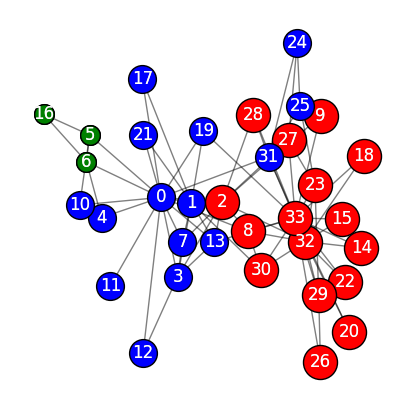

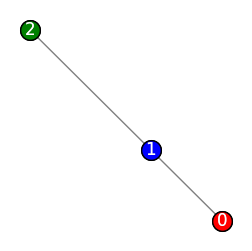

In [3]:
from cdlib import algorithms
from cdlib import viz

g = nx.karate_club_graph()
lp_coms = algorithms.label_propagation(g)

pos = nx.spring_layout(g)
viz.plot_network_clusters(g, lp_coms, pos, figsize=(5, 5), plot_overlaps=True, plot_labels=True) #, top_k=2)
viz.plot_community_graph(g, lp_coms, figsize=(3, 3), plot_overlaps=False, plot_labels=True)
plt.show()

In [4]:
MODEL_FILENAME = '../jpetstore/jpetstore_128scenarios_nopolicies_sobol' #.tar.gz'
# MODEL_FILENAME = '../cargo/cargo_128scenarios_nopolicies_sobol' #.tar.gz'


experiments_df, outcomes = load_results(MODEL_FILENAME+ '.tar.gz')
experiments_df['beta'] = 100 - experiments_df['alpha']
outcomes_df = pd.DataFrame(outcomes)
print(experiments_df.shape, outcomes_df.shape)

with open(MODEL_FILENAME+'_model.pkl', 'rb') as input:
    uncertainties_problem = pickle.load(input)
with open(MODEL_FILENAME+'_partitions.pkl', 'rb') as input:
    partitions_dict = pickle.load(input)
    print(len(partitions_dict.keys()), "clusters")

(1280, 8) (1280, 3)
1212 clusters


In [5]:
experiments_df.head()

,alpha,mfuzzy,microservice_threshold,resolution,scenario,policy,model,beta
0,97,9,4,59,0,NaN,jpetstore,3
1,51,9,4,59,1,NaN,jpetstore,49
2,97,4,4,59,2,NaN,jpetstore,3
3,97,9,8,59,3,NaN,jpetstore,3
4,97,9,4,6,4,NaN,jpetstore,3


In [6]:
experiments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280 entries, 0 to 1279
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   alpha                   1280 non-null   int64   
 1   mfuzzy                  1280 non-null   int64   
 2   microservice_threshold  1280 non-null   int64   
 3   resolution              1280 non-null   int64   
 4   scenario                1280 non-null   category
 5   policy                  0 non-null      category
 6   model                   1280 non-null   category
 7   beta                    1280 non-null   int64   
dtypes: category(3), int64(5)
memory usage: 97.6 KB


In [7]:
experiments_df.describe()

,alpha,mfuzzy,microservice_threshold,resolution,beta
count,1280.000000,1280.000000,1280.000000,1280.000000,1280.000000
mean,50.511719,6.011719,5.992188,50.511719,49.488281
std,28.869768,2.583224,2.580967,28.898055,28.869768
min,1.000000,2.000000,2.000000,1.000000,0.000000
25%,25.750000,4.000000,4.000000,25.750000,24.750000
50%,50.500000,6.000000,6.000000,50.500000,49.500000
75%,75.250000,8.000000,8.000000,75.250000,74.250000
max,100.000000,10.000000,10.000000,100.000000,99.000000


In [8]:
outcomes

{'n_partitions': array([7, 7, 7, ..., 7, 6, 8]),
 'modularity': array([-0.00421639, -0.00421639, -0.00421639, ..., -0.00513278,
        -0.00637119, -0.00488036]),
 'noise_classes': array([17, 17, 17, ..., 17, 17, 17])}

In [9]:
outcomes_df.head()

,n_partitions,modularity,noise_classes
0,7,-0.004216,17
1,7,-0.004216,17
2,7,-0.004216,17
3,7,-0.004216,17
4,8,-0.003689,17


In [10]:
outcomes_df.describe()

,n_partitions,modularity,noise_classes
count,1280.000000,1280.000000,1280.0
mean,7.164062,-0.006434,17.0
std,0.804380,0.008538,0.0
min,5.000000,-0.120193,17.0
25%,7.000000,-0.004919,17.0
50%,7.000000,-0.004216,17.0
75%,8.000000,-0.004216,17.0
max,10.000000,-0.002951,17.0


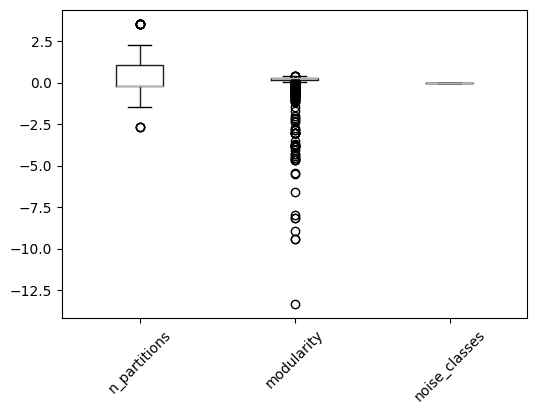

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
outcomes_scaled = scaler.fit_transform(outcomes_df)
outcomes_scaled_df = pd.DataFrame(outcomes_scaled, columns=outcomes_df.columns)

boxplot = outcomes_scaled_df.boxplot(grid=False, figsize=(6,4), rot=45)
plt.show()

In [12]:
df = pd.concat([experiments_df, outcomes_df], axis=1)

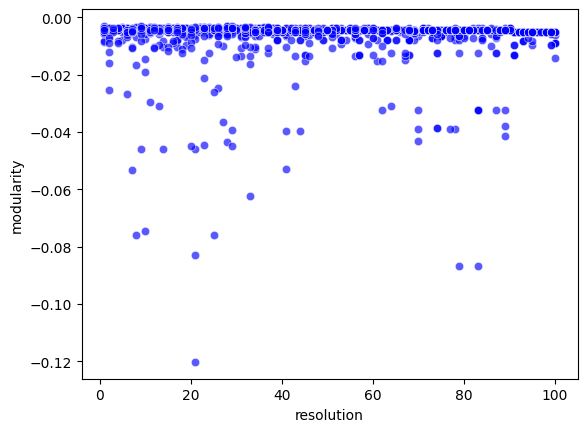

In [13]:
sns.scatterplot(data=df, x="resolution", y="modularity", alpha=0.65, color='blue')
plt.show()

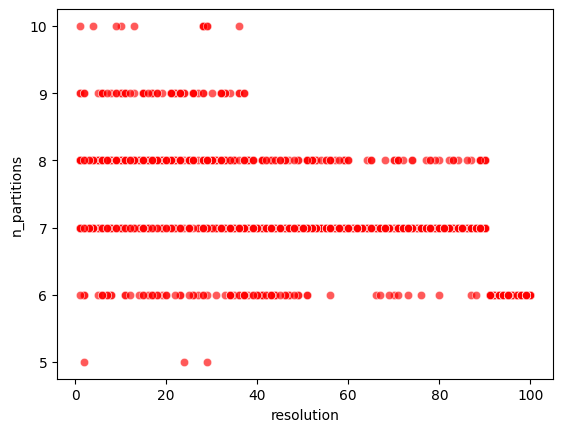

In [14]:
sns.scatterplot(data=df, x="resolution", y="n_partitions", alpha=0.65, color='red')
plt.show()

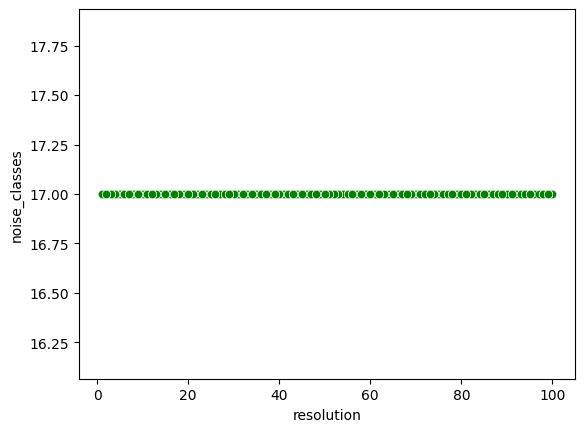

In [15]:
sns.scatterplot(data=df, x="resolution", y="noise_classes", alpha=0.65, color='green')
plt.show()

In [16]:
# Visualization of scenarios
def show_pairplot(experiments, outcomes, kind='sns', title='', group='scenario', filename=None):
    if kind == 'sns':
        data = pd.DataFrame(outcomes)
        policies = experiments['scenario']
        data['scenario'] = policies
        g = sns.pairplot(data, hue=group, vars=list(outcomes.keys()), corner=True, plot_kws={'alpha':0.25})
        g._legend.remove()
        g.fig.suptitle(title)
        if filename is not None:
            plt.savefig(filename)
        plt.show()
    if kind == 'matplotlib':
        data = experiments.copy()
        data['scenario'] = experiments['scenario'].astype(str)
        fig, axes = pairs_plotting.pairs_scatter(data, outcomes, group_by=group,legend=False)
        fig.set_size_inches(8,8)
        fig.suptitle(title)
        if filename is not None:
            plt.savefig(filename)
        plt.show()

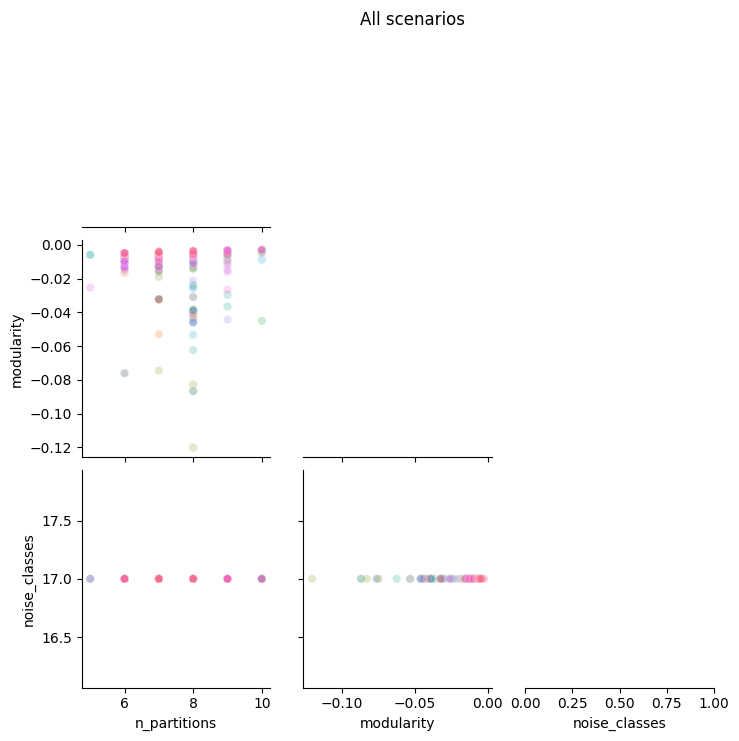

In [17]:
show_pairplot(experiments_df, outcomes, title='All scenarios', kind='sns')

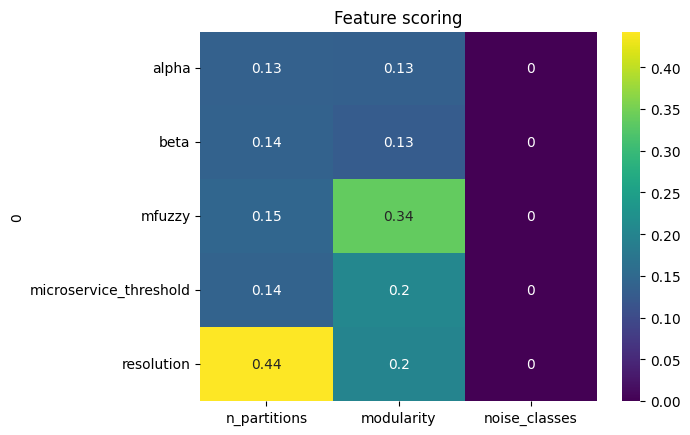

,n_partitions,modularity,noise_classes
0,,,
alpha,0.134994,0.133756,0.0
beta,0.137514,0.126441,0.0
mfuzzy,0.145254,0.335865,0.0
microservice_threshold,0.139389,0.204850,0.0
resolution,0.442850,0.199088,0.0


In [18]:
fs = feature_scoring.get_feature_scores_all(experiments_df, outcomes) #, mode=feature_scoring.CLASSIFICATION)
sns.heatmap(fs, cmap='viridis', annot=True)
plt.title('Feature scoring')
plt.show()
fs

In [19]:
# For parameters
# uncertainties_problem = get_SALib_problem(model.uncertainties)
print('----', 'n_partitions')
Si_1 = sobol.analyze(uncertainties_problem, outcomes['n_partitions'], calc_second_order=True, print_to_console=True)
print('----', 'modularity')
Si_2 = sobol.analyze(uncertainties_problem, outcomes['modularity'], calc_second_order=True, print_to_console=True)
print('----', 'noise_classes')
Si_3 = sobol.analyze(uncertainties_problem, outcomes['noise_classes'], calc_second_order=True, print_to_console=True)

---- n_partitions
                              ST   ST_conf
alpha                   0.550562  0.254304
mfuzzy                  0.674157  0.230969
microservice_threshold  0.623596  0.187288
resolution              0.960674  0.201501
                              S1   S1_conf
alpha                  -0.094101  0.140717
mfuzzy                 -0.067942  0.191055
microservice_threshold -0.080671  0.154979
resolution              0.432145  0.309335
                                            S2   S2_conf
(alpha, mfuzzy)                       0.163009  0.222202
(alpha, microservice_threshold)       0.174245  0.209919
(alpha, resolution)                  -0.129126  0.260563
(mfuzzy, microservice_threshold)      0.166871  0.221235
(mfuzzy, resolution)                  0.043276  0.266235
(microservice_threshold, resolution) -0.011412  0.255397
---- modularity
                              ST   ST_conf
alpha                   0.421726  1.603682
mfuzzy                  0.771902  3.183255
microser

In [20]:
def show_sobol(problem, Si, title='', filename=None):
    scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
    Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

    sns.set_style('white')
    fig, ax = plt.subplots(1)

    indices = Si_df[['S1','ST']]
    err = Si_df[['S1_conf','ST_conf']]

    indices.plot.bar(yerr=err.values.T,ax=ax)
    fig.set_size_inches(8,6)
    fig.subplots_adjust(bottom=0.3)
    plt.title(title)
    if filename is not None:
        plt.savefig(filename)
    plt.show()

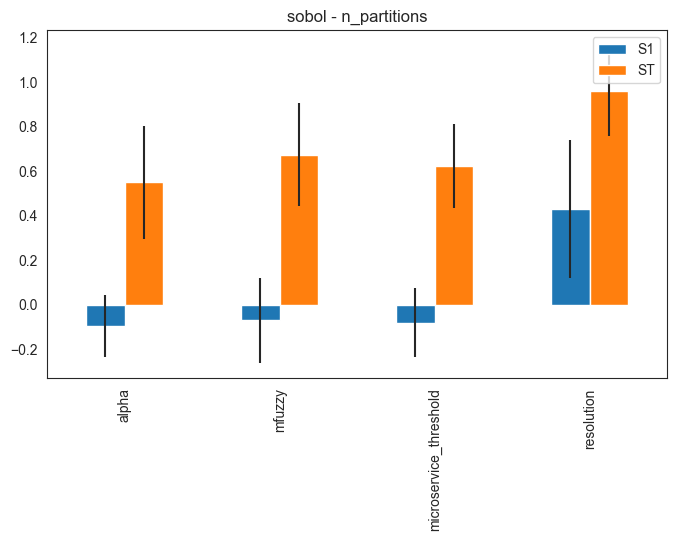

In [21]:
show_sobol(uncertainties_problem, Si_1, title='sobol - n_partitions')

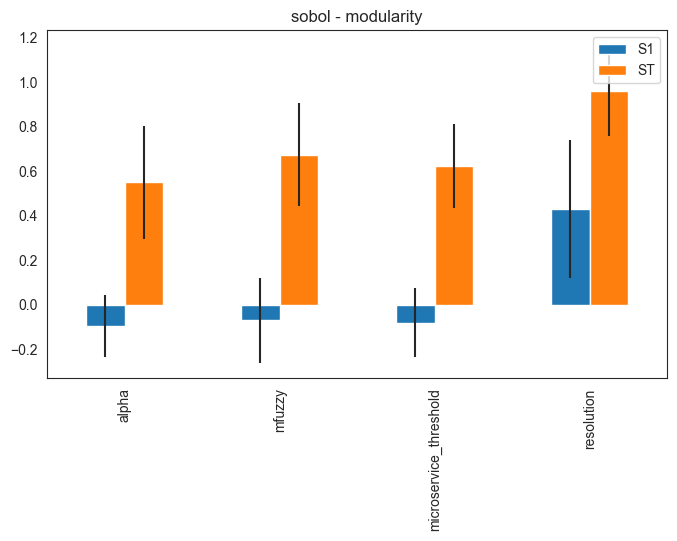

In [22]:
show_sobol(uncertainties_problem, Si_2, title='sobol - modularity')

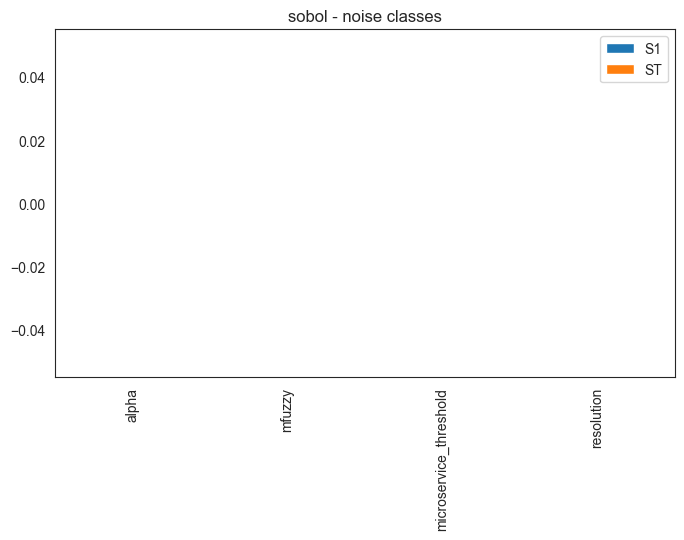

In [23]:
show_sobol(uncertainties_problem, Si_3, title='sobol - noise classes')
